In [8]:
import tensorflow as tf
import os
import sys
 
import numpy as np
 
from tqdm import tqdm
from itertools import chain
 
from skimage.io import imread, imshow

from skimage.transform import resize
import random
import matplotlib.pyplot as plt

In [9]:
tf.__version__

'1.15.0'

TensorFlow2.0中将对部分机制做出重大调整，其中之一就是将原有的静态图机制（使用静态图的TensorFlow工作流程如下图所示）调整为动态图机制，这将使得TensorFlow更加灵活和易用，在2.0版本到来之前，我们可以通过 tf.enable_eager_execution() 方法来启用动态图机制。

<img src="./pics/tf1.png", width=120, height=90>

In [4]:
tf.enable_eager_execution()

In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
 
DATA_PATH = 'stage1_train/'
 
seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[1]
 
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
 
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
    path = DATA_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y[n] = mask

x_train=X
y_train=Y

100%|██████████| 670/670 [02:25<00:00,  4.61it/s]


<img src="./pics/UNet.png", width=800, height=480>

keras.layers.Concatenate(axis=-1)

In [11]:
# Build U-Net model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c5)
 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3yo renreng
                                  , 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation=tf.keras.activations.elu, kernel_initializer='he_normal',
                            padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [12]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)
 
callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  tf.keras.callbacks.TensorBoard(log_dir='./logs'),
  cp_callback 
]
 
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=20,
                    callbacks=callbacks)
 

Train on 603 samples, validate on 67 samples
Epoch 1/20
560/603 [==========================>...] - ETA: 0s - loss: 0.3554 - acc: 0.8471
Epoch 00001: saving model to training_1/cp.ckpt
603/603 [==============================] - 2s 3ms/sample - loss: 0.3460 - acc: 0.8517 - val_loss: 0.2177 - val_acc: 0.9171
Epoch 2/20
592/603 [============================>.] - ETA: 0s - loss: 0.1697 - acc: 0.9323
Epoch 00002: saving model to training_1/cp.ckpt
603/603 [==============================] - 1s 1ms/sample - loss: 0.1705 - acc: 0.9319 - val_loss: 0.1296 - val_acc: 0.9490
Epoch 3/20
592/603 [============================>.] - ETA: 0s - loss: 0.1436 - acc: 0.9445
Epoch 00003: saving model to training_1/cp.ckpt
603/603 [==============================] - 1s 2ms/sample - loss: 0.1443 - acc: 0.9440 - val_loss: 0.1245 - val_acc: 0.9523
Epoch 4/20
592/603 [============================>.] - ETA: 0s - loss: 0.1315 - acc: 0.9492
Epoch 00004: saving model to training_1/cp.ckpt
603/603 [=====================

1/1 [==============================] - 0s 2ms/sample


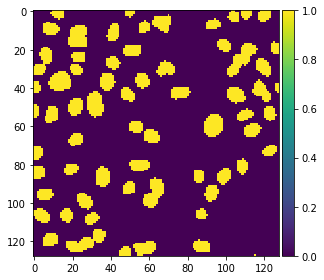

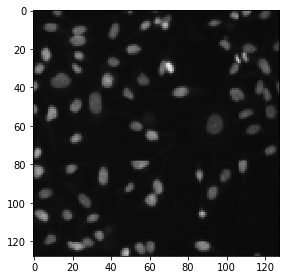

In [17]:
idx = random.randint(0, len(x_train)-1)
x=np.array(x_train[idx])
x=np.expand_dims(x, axis=0)
predict = model.predict(x, verbose=1)
 
predict = (predict > 0.5).astype(np.uint8)
 
imshow(np.squeeze(predict[0]))
plt.show()
 
imshow(x_train[idx])
 
plt.show()